# 1. Visualización de un catálogo simulado completo

#### - Explora los cambios en los catálogos en función del modelo de falla que se asume (geometría, tasa de deslizamiento, etc.)
#### - Corre las distintas celdas para cada uno de los catálogos y guarda las gráficas para compararlas.


In [24]:
#Import the necessary libraries

#%matplotlib widget
import ipympl
import os
import json
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import ScalarFormatter
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

### Selecciona la carpeta correspondiente a cada uno de los modelos dentro de la carpeta "Catalogues"

In [33]:
# Extract the catalogue

cat = "Falla_planar" #Pon aquí el nombre de la carpeta del catálogo correspondiente

path = os.getcwd()
path = os.path.abspath(os.path.join(path, "../"+ "/Catalogues/"))
path = path+"/"+cat

file = os.path.join(path, "data.json")
with open(file, "r") as file:
    catalog = json.load(file)

Ev_per_patch = {key: catalog[key] for key in catalog.keys() & {"eList", "pList", "dList", "tList", "dtauList", "M", "M0", "area", "x", "y", "z"}}

# Filter events by year number

cut_year = 20000
t0_ini = list(catalog.values())[-2]
z_ini = Ev_per_patch.get("z")
loc_cut = np.where(np.array(t0_ini)>cut_year)[0][0]
M_ini = np.array(Ev_per_patch.get("M"))[loc_cut:]
M_ini = [float(i) for i in M_ini]
M0_ini = np.array(Ev_per_patch.get("M0"))[loc_cut:]
M0_ini = [float(i) for i in M0_ini]
area_ini = np.array(Ev_per_patch.get("area"))[loc_cut:]
num_events_ini = list(range(1, len(M_ini)+1))+loc_cut
x_ini = np.array(Ev_per_patch.get("x"))[loc_cut:]
y_ini = np.array(Ev_per_patch.get("y"))[loc_cut:]
z_ini = np.array(Ev_per_patch.get("z"))[loc_cut:]
Depth_ini = np.array(Ev_per_patch.get("z"))[loc_cut:]
t0_ini = np.array(t0_ini)[loc_cut:]

eList_ini = Ev_per_patch.get("eList")
loc_list_cut = np.where(np.array(eList_ini)==num_events_ini[0])[0][0]
eList_ini = np.array(eList_ini)[loc_list_cut:]
pList_ini = np.array(Ev_per_patch.get("pList"))[loc_list_cut:]
dList_ini = np.array(Ev_per_patch.get("dList"))[loc_list_cut:]
dtauList_ini = np.array(Ev_per_patch.get("dtauList"))[loc_list_cut:]
tList_ini = np.array(Ev_per_patch.get("tList"))[loc_list_cut:]

# Completness

mag_range = np.arange(0, 8, 0.1)
hist, bins = np.histogram(M_ini, bins=mag_range)
Mc = bins[np.argmax(hist)]
Mc_2 = Mc

idx_Mc = [x > Mc_2 for x in M_ini]
M_ini = (np.array(M_ini))[idx_Mc]
M0_ini = (np.array(M0_ini))[idx_Mc]
area_ini = (np.array(area_ini))[idx_Mc]
num_events_ini = (np.array(num_events_ini))[idx_Mc]
t0_ini = (np.array(t0_ini))[idx_Mc]
x_ini = (np.array(x_ini))[idx_Mc]
y_ini = (np.array(y_ini))[idx_Mc]
z_ini= (np.array(z_ini))[idx_Mc]

idx_Mc_all = np.where(np.isin(eList_ini, num_events_ini))[0]
eList_ini = np.float64((np.array(eList_ini))[idx_Mc_all])
pList_ini = np.float64((np.array(pList_ini))[idx_Mc_all])
dList_ini = np.float64((np.array(dList_ini))[idx_Mc_all])
dtauList_ini = np.float64((np.array(dtauList_ini))[idx_Mc_all])
tList_ini = np.float64((np.array(tList_ini))[idx_Mc_all])

### Visualiza el modelo de falla utilizado

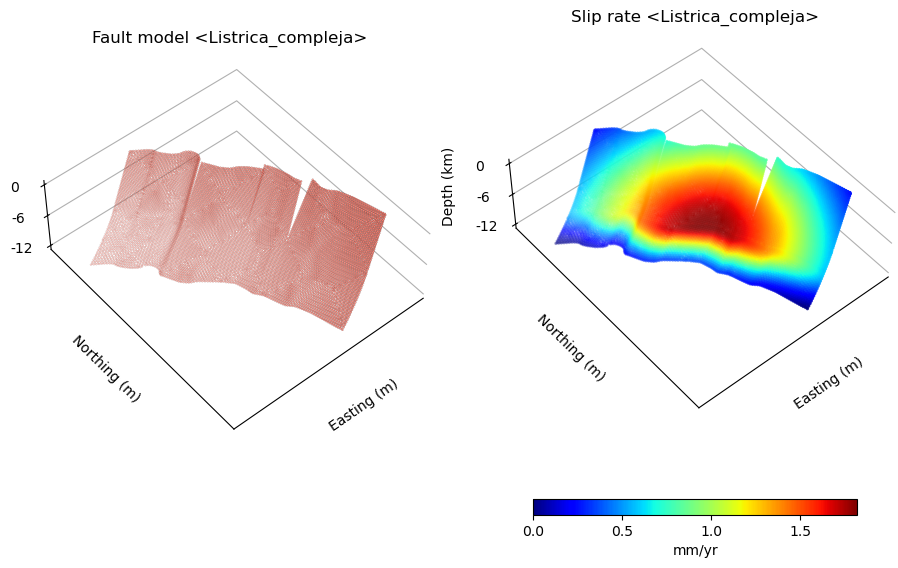

In [35]:
# Extract fault model


fault = os.path.join(path + "/fault.flt")
if cat == "Sistema_EBSZ":
    input_file = pd.read_csv(fault, delimiter=";", header=None)
    input_file.iloc[:,0:8] = input_file.iloc[:,0:8]*1000
else:
    input_file = pd.read_csv(fault, delimiter=" ", header=None)

u_flt, locs_flt = np.unique(input_file.iloc[:, -1], return_index=True)
locs_flt = np.concatenate((locs_flt, np.array([len(input_file) + 1])))

x1 = input_file.iloc[:, 0]
x2 = input_file.iloc[:, 3]
x3 = input_file.iloc[:, 6]
y1 = input_file.iloc[:, 1]
y2 = input_file.iloc[:, 4]
y3 = input_file.iloc[:, 7]
z1 = input_file.iloc[:, 2]
z2 = input_file.iloc[:, 5]
z3 = input_file.iloc[:, 8]

file = np.column_stack((x1, x2, x3, y1, y2, y3, z1, z2, z3, np.array(range(1, len(input_file) + 1))))

x_center = (file[:, 0] + file[:, 1] + file[:, 2]) / 3
y_center = (file[:, 3] + file[:, 4] + file[:, 5]) / 3
z_center = (file[:, 6] + file[:, 7] + file[:, 8]) / 3

# Find patches that are located at the surface

init_depth = 0
con_2 = (file[:, 6] >= init_depth) & (file[:, 7] >= init_depth)
con_3 = (file[:, 7] >= init_depth) & (file[:, 8] >= init_depth)
con_4 = (file[:, 6] >= init_depth) & (file[:, 8] >= init_depth)
con_2 = np.where(con_2)[0]
con_3 = np.where(con_3)[0]
con_4 = np.where(con_4)[0]
z_1 = np.concatenate((con_2, con_3, con_4))
z_filter, reps = np.unique(z_1, return_index=False, return_counts=True)

#Plot fault model

fig, ax = plt.subplots(1,2, figsize=(11,7), subplot_kw=dict(projection='3d'))
xs = np.column_stack((x1,x2,x3))
ys = np.column_stack((y1,y2,y3))
zs = np.column_stack((z1,z2,z3))
cmap = plt.cm.jet
slip_rates = input_file.iloc[:,10]*(3600*365*1000*24)
colors = cmap(slip_rates)
vmin = 0
vmax = 2
norm = Normalize(vmin=0, vmax=max(slip_rates))
colors = cmap(norm(slip_rates))
#triangles=[]
#for ca in range(0, len(x1)):
   # triangle = [
       # [xs[ca,0], ys[ca,0], zs[ca,0]],
      #  [xs[ca,1], ys[ca,1], zs[ca, 1]],
     #   [xs[ca,2], ys[ca,2], zs[ca,2]]]
    #triangles.append(triangle)
    #ax[0].plot_trisurf(xs[ca,:], ys[ca,:], zs[ca,:], triangles=triangle[0], facecolor='lightcoral', edgecolors='black', linewidth=0.05, zorder=1)
    #x=ax[1].plot_trisurf(xs[ca,:], ys[ca,:], zs[ca,:], triangles=triangle[0], facecolor=colors[ca], edgecolors='black', linewidth=0.05, zorder=1)


ax[0].scatter(x_center, y_center, z_center, c="salmon", s=2, marker="o", edgecolor="black", linewidth=0.1)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].zaxis.set_ticks([-12000, -6000, 0])
ax[0].zaxis.set_ticklabels([-12,-6,0])
ax[0].zaxis.set_rotate_label(False)
ax[0].set_zlabel("Depth (km)", fontsize = 10, rotation = 90)
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].xaxis.pane.set_visible(False)
ax[0].yaxis.pane.set_visible(False)
ax[0].zaxis.pane.set_visible(False)
x = ax[1].scatter(x_center, y_center, z_center, c=input_file.iloc[:,10]*(3600*365*1000*24), s=2, marker="o", cmap="jet")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].zaxis.set_ticks([-12000, -6000, 0])
ax[1].zaxis.set_ticklabels([-12,-6,0])
ax[1].zaxis.set_rotate_label(False)
ax[1].set_zlabel("Depth (km)", fontsize = 10, rotation = 90)
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].xaxis.pane.set_visible(False)
ax[1].yaxis.pane.set_visible(False)
ax[1].zaxis.pane.set_visible(False)
sm = ScalarMappable(cmap=cmap)
sm.set_clim(0, max(slip_rates))
cbar=fig.colorbar(sm, ax=ax[1], cmap="jet", orientation='horizontal', fraction =0.03)
cbar.set_label('mm/yr', fontsize=10)  # Set the label for the colorbar
    
ax[0].set_xlabel("Easting (m)")
ax[0].set_ylabel("Northing (m)")
ax[0].set_aspect("equalyz")
ax[0].set_title ("Fault model "+ "<"+cat+">")
ax[1].set_xlabel("Easting (m)")
ax[1].set_ylabel("Northing (m)")
if cat == "Sistema_NZ":
    ax[0].view_init(50)
    ax[1].view_init(50)
elif cat == "Sistema_EBSZ":
    ax[0].view_init(50, -90)
    ax[1].view_init(50, -90)
else:
    ax[0].view_init(50, -130)
    ax[1].view_init(50, -130)
ax[1].set_aspect("equalyz")
ax[1].set_title ("Slip rate "+ "<"+cat+">")
plt.show()

### Visualiza el catálogo

#### Evolucion temporal de la magnitud y el momento sísmico: ciclo sísmico. 
####

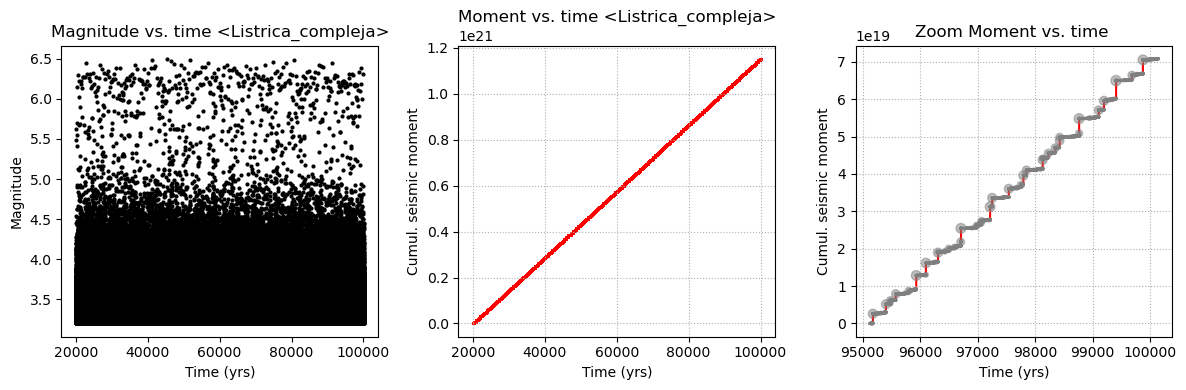

In [36]:
# Plots of the catalogue

percentage_for_zoom = 95

t = (percentage_for_zoom*0.01)*max(t0_ini) # Year for zoom
loc_t = np.where(t0_ini>t)[0]

fig2, ax2 = plt.subplots(1, 3, figsize=(12,4))
ax2[0].scatter(t0_ini, M_ini, s=4, c="black")
ax2[1].scatter(t0_ini, np.cumsum(M0_ini), s=1, c= "red")
ax2[2].plot(t0_ini[loc_t], np.cumsum(M0_ini[loc_t]), color= "red", zorder=1)
ax2[2].scatter(t0_ini[loc_t], np.cumsum(M0_ini[loc_t]), s=np.exp(M_ini[loc_t]**1.1)/40, c= "grey", zorder=2, alpha = 0.5)
ax2[0].set_ylabel("Magnitude")
ax2[0].set_title("Magnitude vs. time "+ "<"+cat+">")
ax2[1].set_ylabel("Cumul. seismic moment")
ax2[1].set_title("Moment vs. time "+ "<"+cat+">")
ax2[2].set_title("Zoom Moment vs. time ")
ax2[2].set_ylabel("Cumul. seismic moment")
ax2[0].set_xlabel("Time (yrs)")
ax2[1].set_xlabel("Time (yrs)")
ax2[2].set_xlabel("Time (yrs)")
ax2[1].grid('on', which="major", linestyle=":")
ax2[2].grid('on', which="major", linestyle=":")
plt.tight_layout()
plt.show()

#### Distribución magnitud-frecuencia del catálogo (MFD)

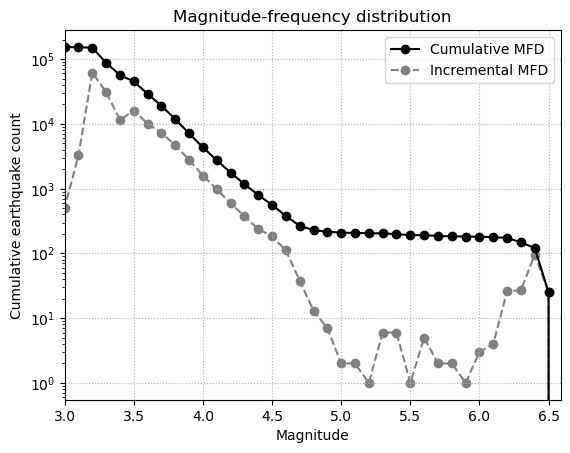

In [31]:
#Plot the Magnitude-frequency distribution

fig3, ax3 = plt.subplots()
ax3.plot(mag_range[:-1], np.flip(np.cumsum(hist[::-1])), c="black", marker ="o", zorder=2)
ax3.plot(mag_range[:-1], hist, c= "grey", marker ="o", linestyle="--", zorder=1)
ax3.set_yscale("log")
ax3.set_xlim(Mc-0.2, max(M_ini))
ax3.set_ylabel("Cumulative earthquake count")
ax3.set_xlabel("Magnitude")
ax3.set_title("Magnitude-frequency distribution")
ax3.legend(["Cumulative MFD", "Incremental MFD"])
ax3.grid('on', which='major', linestyle=":")
plt.show()

#### Profundidad hipocentral (nucleación) de los terremotos

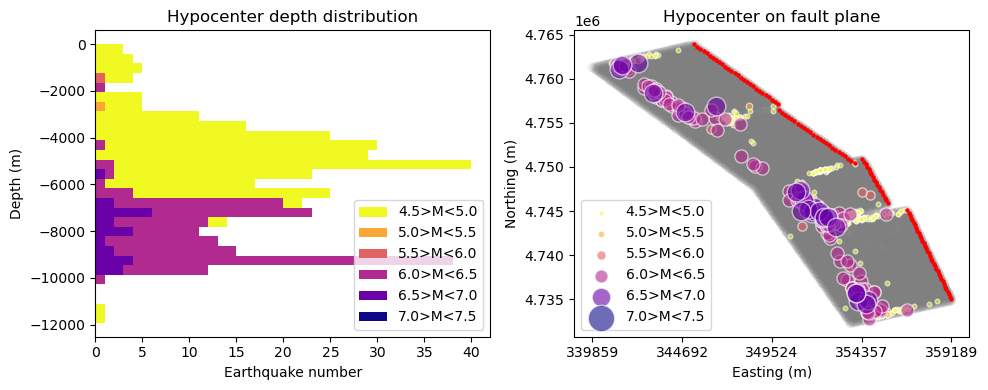

In [32]:
#Location of events at depth

depths = np.linspace(math.ceil(min(z_ini)),0, 30)
M_range = np.arange(4.5, math.floor(round(max(M_ini)))+0.5, 0.5)
cmap = plt.cm.plasma_r
colors = cmap(np.linspace(0, 1, len(M_range)))

fig4, ax4 = plt.subplots(1,2, figsize=(10,4))
c=-1
for i in M_range:
    c=c+1
    alphas = np.linspace(0.1, 1, len(M_range))
    loc_M = np.where((M_ini>=i)&(M_ini<=i+0.5))[0]
    Zs = z_ini[loc_M]
    ax4[0].hist(Zs, bins=depths, stacked=True, orientation='horizontal', label = str(i)+">M<"+str(i+0.5), color=colors[c], alpha = 1)
    ax4[1].scatter(x_ini[loc_M], y_ini[loc_M], s=((np.exp(i))**1.4)/50, zorder=2,label = str(i)+">M<"+str(i+0.5), color=colors[c], alpha = 0.6, edgecolor="w")
    ax4[0].legend()
    ax4[1].legend()
ax4[1].scatter(x_center, y_center, c="grey", alpha=0.1, zorder=1)
ax4[1].scatter(x_center[z_filter], y_center[z_filter], c="red", zorder=2, s=5)
ax4[0].set_ylabel("Depth (m)")
ax4[0].set_xlabel("Earthquake number")
ax4[0].set_title("Hypocenter depth distribution")
ax4[1].set_ylabel("Northing (m)")
ax4[1].set_xlabel("Easting (m)")
ax4[1].set_title("Hypocenter on fault plane")
ax4[1].set_xticks(np.linspace(min(x_center), max(x_center), 5))
plt.tight_layout()
plt.show()